In [1]:
import os
import torch


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [4]:
dataset=Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('===============')
print(f'Number of graph: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')




Processing...
Done!


Dataset: Cora():
Number of graph: 1
Number of features: 1433
Number of classes: 7


In [5]:
data=dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


###Train Model GCN

In [6]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_chanels):
        super().__init__()
        self.conv1=GCNConv(dataset.num_features,hidden_chanels)
        self.conv2=GCNConv(hidden_chanels,dataset.num_classes)

    def forward(self,x,edge_index):
        x=self.conv1(x,edge_index)
        x=x.relu()
        # do not overfitting
        x=F.dropout(x,p=0.5,training=self.training) 

        x=self.conv2(x,edge_index)
        return x


In [7]:
model=GCN(hidden_chanels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [14]:
# Visualize Model Data

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h,color):
    z=TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:,0],z[:,1],s=70,c=color,cmap="Set2")
    plt.show()

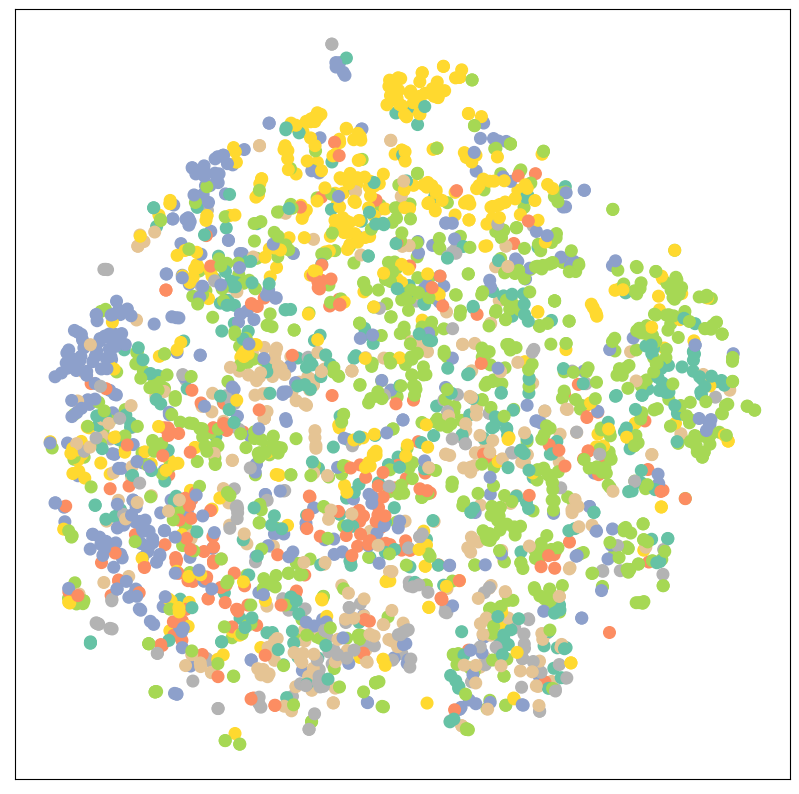

In [15]:
model.eval()
out=model(data.x,data.edge_index)
visualize(out,color=data.y)

In [17]:
# Build Model GCN
model = GCN(hidden_chanels=16)
opt = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
cr = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    opt.zero_grad()
    out=model(data.x,data.edge_index)
    loss=cr(out[data.train_mask],data.y[data.train_mask])
    # Back Propagation to Adjust Parameters of Model weight, Biass
    loss.backward()
    opt.step()
    return loss

def test():
    model.eval()
    out=model(data.x,data.edge_index)
    pred=out.argmax(dim=1)
    test_correct=pred[data.test_mask]==data.y[data.test_mask]
    test_acc=int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc


In [18]:
# Train Model GCN
n_epoch=100
for epoch in range(1,n_epoch+1):
    loss=train()
    print("Epoch {}. Loss ={}".format(epoch,loss))

Epoch 1. Loss =1.946073293685913
Epoch 2. Loss =1.9409353733062744
Epoch 3. Loss =1.9341354370117188
Epoch 4. Loss =1.9260064363479614
Epoch 5. Loss =1.9194762706756592
Epoch 6. Loss =1.909974217414856
Epoch 7. Loss =1.898742914199829
Epoch 8. Loss =1.8919464349746704
Epoch 9. Loss =1.8754185438156128
Epoch 10. Loss =1.8697401285171509
Epoch 11. Loss =1.8528255224227905
Epoch 12. Loss =1.839356541633606
Epoch 13. Loss =1.8291347026824951
Epoch 14. Loss =1.8143852949142456
Epoch 15. Loss =1.8021284341812134
Epoch 16. Loss =1.7832063436508179
Epoch 17. Loss =1.7683119773864746
Epoch 18. Loss =1.7565727233886719
Epoch 19. Loss =1.7217075824737549
Epoch 20. Loss =1.7223821878433228
Epoch 21. Loss =1.690007209777832
Epoch 22. Loss =1.6840720176696777
Epoch 23. Loss =1.664011001586914
Epoch 24. Loss =1.6529048681259155
Epoch 25. Loss =1.6609101295471191
Epoch 26. Loss =1.6033776998519897
Epoch 27. Loss =1.6002851724624634
Epoch 28. Loss =1.5566635131835938
Epoch 29. Loss =1.5464069843292236


In [19]:
#  Test accuracy
test_acc=test()
print(f'Test Accuracy: {test_acc:0.4f}')


Test Accuracy: 0.8140


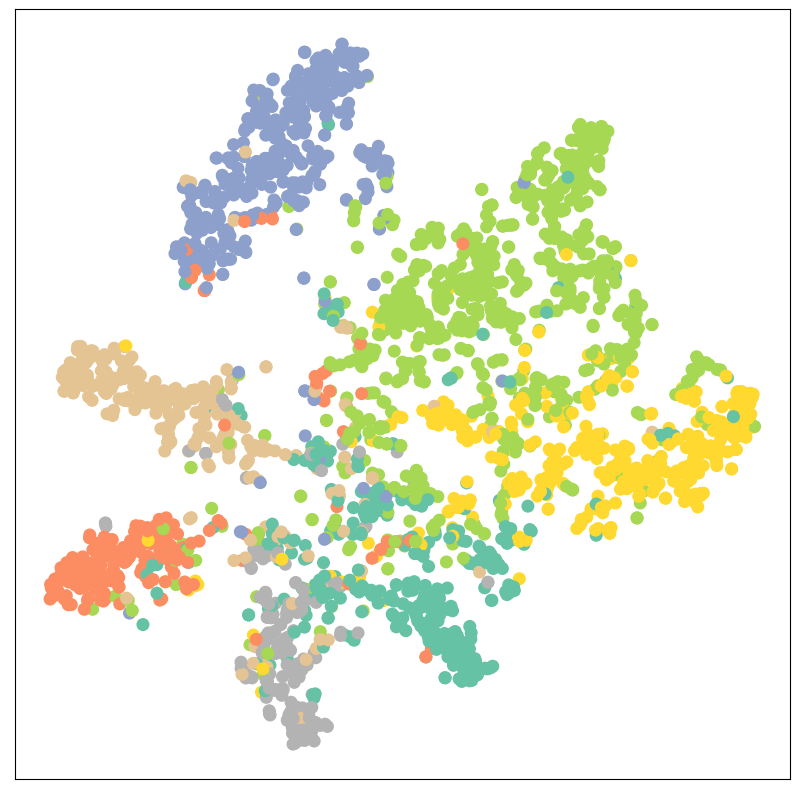

In [20]:
# Visualize the Result of Cite-Link and Clustering  - Classification of Data Model
model.eval()
out=model(data.x,data.edge_index)
visualize(out,color=data.y)

In [24]:
# Test Result with some Data points
print(data.y[10],out[10].argmax())

tensor(0) tensor(0)


In [25]:
print(data.y[0],out[0].argmax())

tensor(3) tensor(3)


In [26]:
print(data.y[3],out[3].argmax())

tensor(0) tensor(0)
